In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv(r'supply_chain_data.csv')
df['Revenue generated'] = df['Price']*df['Number of products sold']
df['profit'] = df['Revenue generated'] - df['Costs'] - df['Shipping costs'] - (df['Manufacturing costs']*df['Number of products sold'])
df['margin(%)'] = (df['profit']/df['Revenue generated'])*100

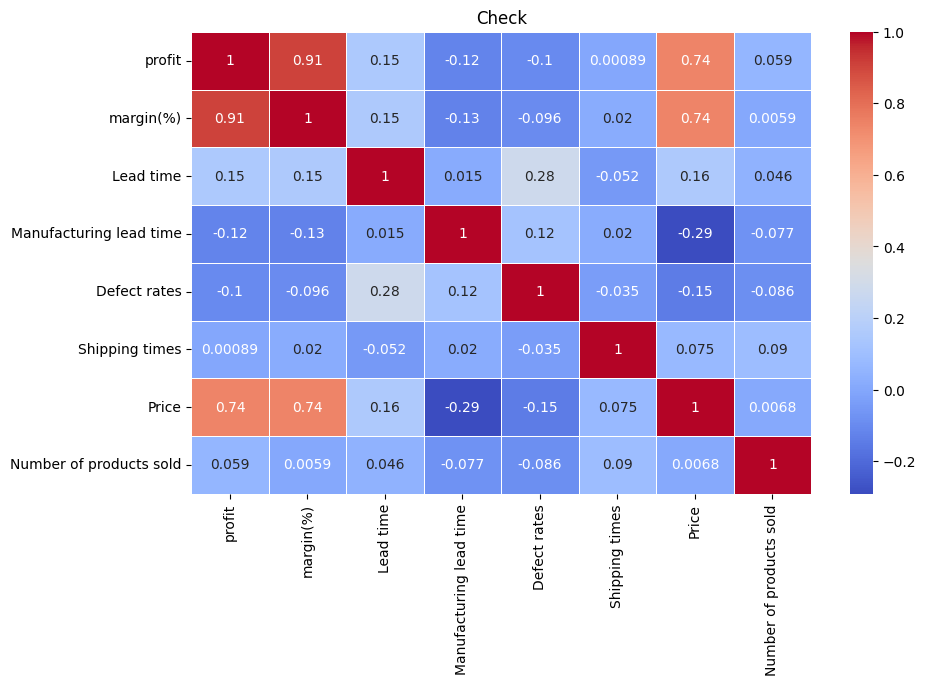

In [127]:
corr_cols = [
    'profit',
    'margin(%)',
    'Lead time',
    'Manufacturing lead time',
    'Defect rates',
    'Shipping times',
    'Price',
    'Number of products sold'
]

corr_df = df[corr_cols].corr(method='spearman')
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()

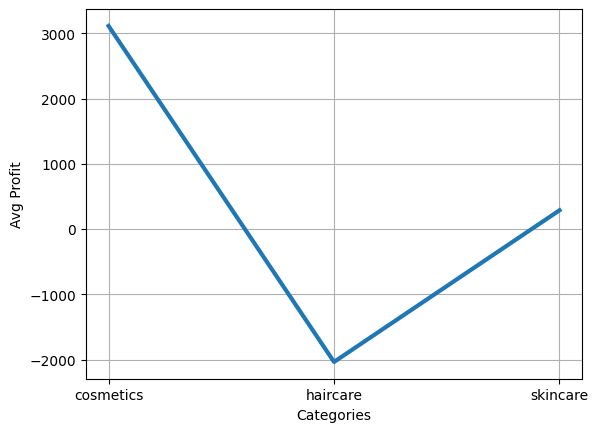

In [128]:
Profit_by_Tproduct = df.groupby('Product type')['profit'].mean().reset_index()
plt.plot(Profit_by_Tproduct['Product type'], Profit_by_Tproduct['profit'], linewidth=3)
plt.grid(True)
plt.xlabel('Categories')
plt.ylabel('Avg Profit')
plt.show() #Product Type haircare is the core of the fails, and a very large one at that.

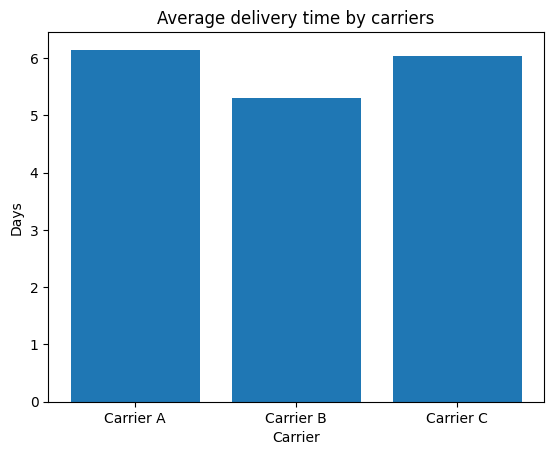

In [129]:
Carriers_and_shipping_time = df.groupby('Shipping carriers')['Shipping times'].mean().reset_index(name='Shipping time (days)')
plt.bar(Carriers_and_shipping_time['Shipping carriers'], Carriers_and_shipping_time['Shipping time (days)'])
plt.title('Average delivery time by carriers')
plt.xlabel('Carrier')
plt.ylabel('Days')
plt.show()

In [130]:
Avg_lead_time_for_production = df.groupby('Product type')['Manufacturing lead time'].mean().reset_index()
Avg_lead_time_for_production

,Product type,Manufacturing lead time
0,cosmetics,13.307692
1,haircare,17.058824
2,skincare,13.775000


In [131]:
df['Manufacturing lead time'].corr(df['profit'])

-0.026736147737485078

In [132]:
Avg_lead_time = df.groupby('Product type')['Lead time'].mean().reset_index()
Avg_lead_time #The full Lead Time = 18.7 days for haircare, and skincare also has critical 18 days Lead Time in avarage

,Product type,Lead time
0,cosmetics,13.538462
1,haircare,18.705882
2,skincare,18.000000


In [133]:
df['Lead time'].corr(df['profit']) #Lead time has negligible impact on profit and should not be treated as a primary optimization lever.

0.12761411547925594

In [134]:
Defect_rates_by_Tproduct = df.groupby('Product type')['Defect rates'].mean().reset_index()
Defect_rates_by_Tproduct #Also, the rate of defects in haircare is higher than in other types of products. Defects in skincare are also quite high.

,Product type,Defect rates
0,cosmetics,1.919287
1,haircare,2.483150
2,skincare,2.334681


In [135]:
df[['Lead time', 'Manufacturing lead time', 'Defect rates']].corrwith(df['profit'], method='spearman')

Lead time                  0.148761
Manufacturing lead time   -0.120872
Defect rates              -0.100486
dtype: float64

In [136]:
our_customers = df.groupby('Customer demographics')['Product type'].value_counts().unstack(fill_value=0).reset_index().head(2)
our_customers = our_customers[['Customer demographics', 'cosmetics', 'haircare', 'skincare']] 
our_customers ##71.1% of orders from the cosmetics section are made by women, 83% of orders from the haircare section are made by men, 65% of orders from the skincare section are made by women.

Product type,Customer demographics,cosmetics,haircare,skincare
0,Female,10,2,13
1,Male,4,10,7


In [137]:
unprofitable_orders = df.sort_values(by='margin(%)', ascending=True)
t= unprofitable_orders[unprofitable_orders['margin(%)'] < 0]
t.groupby('Routes')['margin(%)'].sum()
t['Price'].mean()
t['Manufacturing costs'].mean()
#Based on the data obtained, Path A is the most unprofitable. It was also found that low unit prices and high production costs lead to negative profits.

65.97439195925683

In [138]:
df[['Manufacturing costs', 'Price']].corrwith(df['profit']) #The higher the production price = lower the profit, the higher the price = higher the profit.

Manufacturing costs   -0.615505
Price                  0.688168
dtype: float64

In [139]:
results = df.groupby('Inspection results')['Inspection results'].count()
results

Inspection results
Fail       36
Pass       23
Pending    41
Name: Inspection results, dtype: int64

In [140]:
fail_df = df[df['Inspection results'] == 'Fail']
tr = df.groupby('Transportation modes')['Transportation modes'].count().reset_index(name='c')
tr_f = fail_df.groupby('Transportation modes')['Transportation modes'].count().reset_index(name='cf')
tr = tr.merge(tr_f, how='inner', on='Transportation modes')
tr['Percent_fail'] = (tr['cf']/tr['c'])*100 
tr #The failure rates by transport type are roughly the same, ranging from 34.6% to 38%.
#It’s necessary to analyze transport types in combination with route categories and locations, and to assess the number of failures across these pairings.

,Transportation modes,c,cf,Percent_fail
0,Air,26,9,34.615385
1,Rail,28,10,35.714286
2,Road,29,11,37.931034
3,Sea,17,6,35.294118


In [141]:
roads = df.groupby('Routes')['Inspection results'].value_counts().unstack(fill_value=0)
roads #The most problematic path is A, which requires a more in-depth investigation to determine the cause of such a number of fails.

Inspection results,Fail,Pass,Pending
Routes,,,
Route A,18,6,19
Route B,11,12,14
Route C,7,5,8


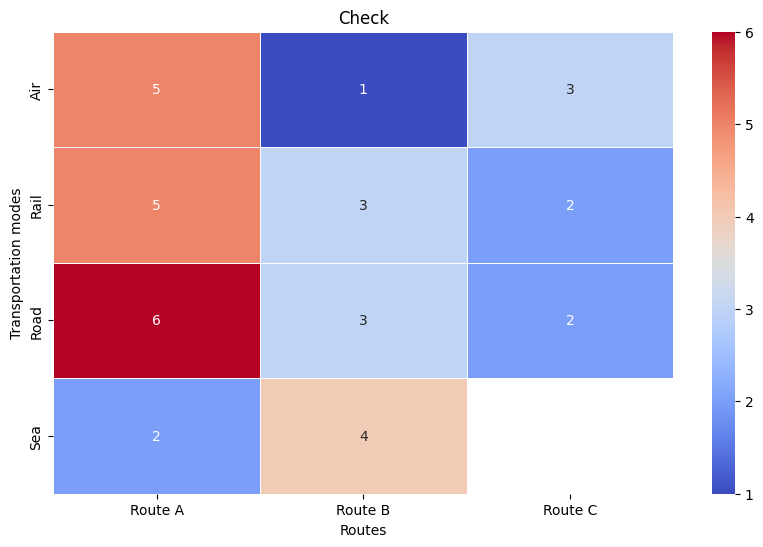

In [142]:
fails_Transport_Routes = fail_df.pivot_table(
    index='Transportation modes',
    columns='Routes',
    values='Inspection results',
    aggfunc='count'
) 
plt.figure(figsize=(10, 6))
sns.heatmap(fails_Transport_Routes, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()
#Route A shows the highest number of failures across Air, Rail, and Road transport.
#Route B records fewer failures overall, though Rail, Road, and Sea still contribute a noticeable share.
#Route C has the lowest failure count on Rail and Road, and reports zero failures for Sea transport.

In [143]:
location_fails = df.groupby('Location')['Inspection results'].value_counts().unstack(fill_value=0).reset_index()
location_fails['per_fails'] = (location_fails['Fail']/(location_fails['Fail'] + location_fails['Pass'] + location_fails['Pending']))*100
location_fails #Fail Leaders Chennai, Delhi, Kolkata

Inspection results,Location,Fail,Pass,Pending,per_fails
0,Bangalore,5,5,8,27.777778
1,Chennai,10,5,5,50.000000
2,Delhi,8,3,4,53.333333
3,Kolkata,8,5,12,32.000000
4,Mumbai,5,5,12,22.727273


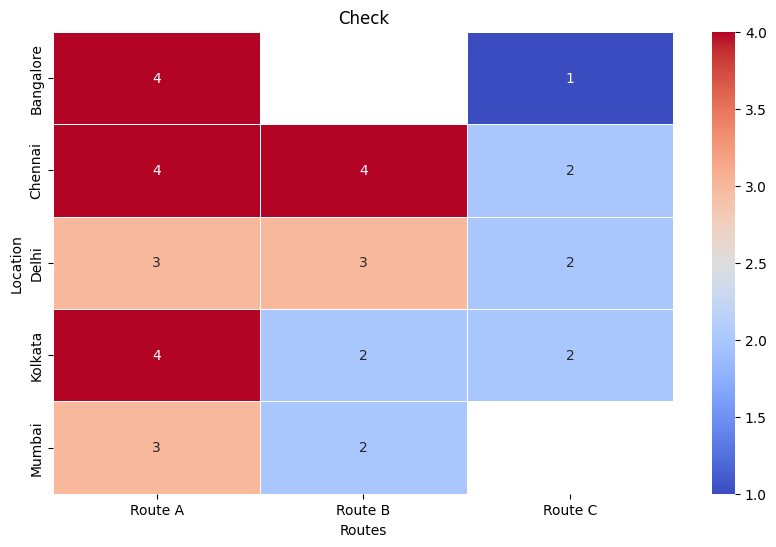

In [144]:
location_routes_pivot = fail_df.pivot_table(
    index='Location',
    columns='Routes',
    values='Inspection results',
    aggfunc='count'
) 

plt.figure(figsize=(10, 6))
sns.heatmap(location_routes_pivot, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()
#From the route–location breakdown, the strongest pairings are Route B + Bangalore, Route C + Mumbai, and Route C + Bangalore (lowest failure counts).

#Route A is consistently failure-heavy across all locations (predominantly “red”), indicating a systemic issue on this route.
#Route B shows a notable improvement vs. Route A, though failures remain moderate in several locations.
#Route C delivers the best overall performance, outperforming Route B and exhibiting the lowest failure levels across the board, especially in the Mumbai and Bangalore pairings.


In [145]:
df.groupby('Routes')['profit'].agg(['mean', 'median', 'count'])

,mean,median,count
Routes,,,
Route A,-1537.648712,-2425.920400,43
Route B,1808.875834,4345.181012,37
Route C,1121.522702,2279.845749,20


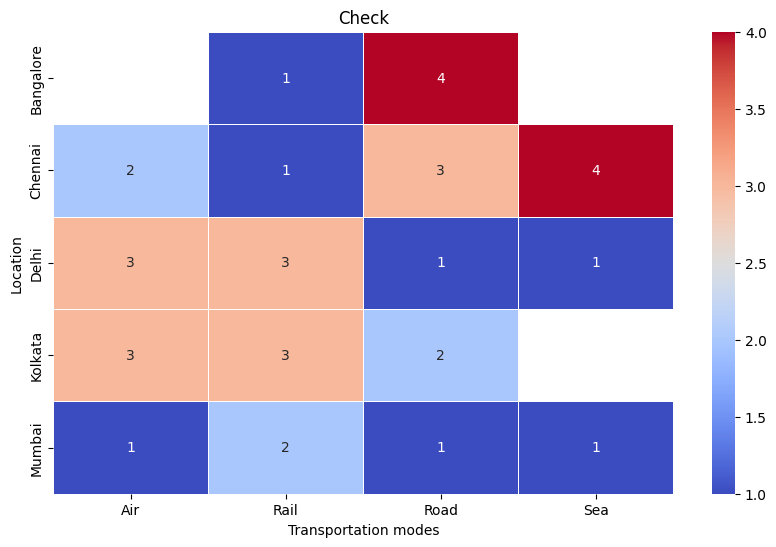

In [146]:
location_transport_pivot = fail_df.pivot_table(
    index='Location',
    columns='Transportation modes',
    values='Inspection results',
    aggfunc='count'
) 
plt.figure(figsize=(10, 6))
sns.heatmap(location_transport_pivot, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()
#The highest concentration of failures by transport mode (location - mode of transport) is observed in the following combinations: Bangalore + road, Chennai + sea, Chennai + road, Delhi + rail, Delhi + air, Kolkata + air and Kolkata + rail.

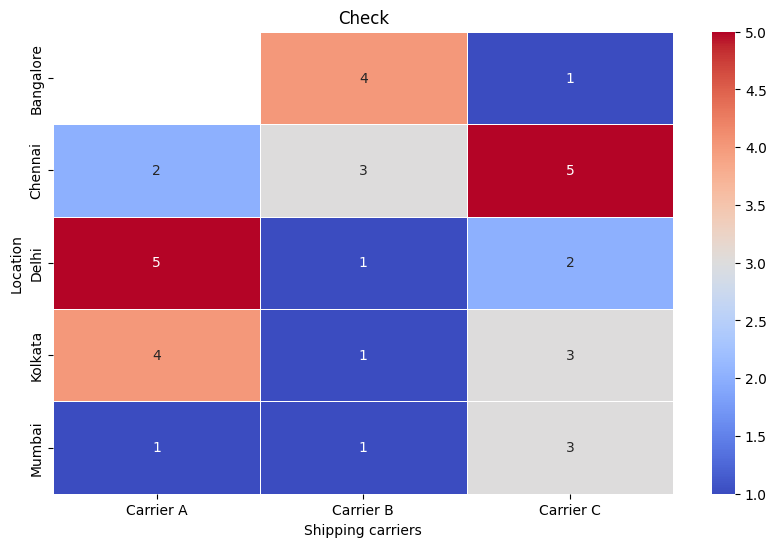

In [147]:
carriers_pivot_location = fail_df.pivot_table(
    index='Location',
    columns='Shipping carriers',
    values='Inspection results',
    aggfunc='count'
) 
plt.figure(figsize=(10, 6))
sns.heatmap(carriers_pivot_location, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()
#Carrier A shows a high (red) failure rate in Delhi and a moderate (orange) failure rate in Kolkata, while no failures are observed in Bangalore.
#Carrier B records failures in Chennai and Bangalore, with no critical hotspots in other regions.
#Carrier C exhibits a high (red) failure rate in Chennai, along with additional failures in Kolkata and Mumbai.


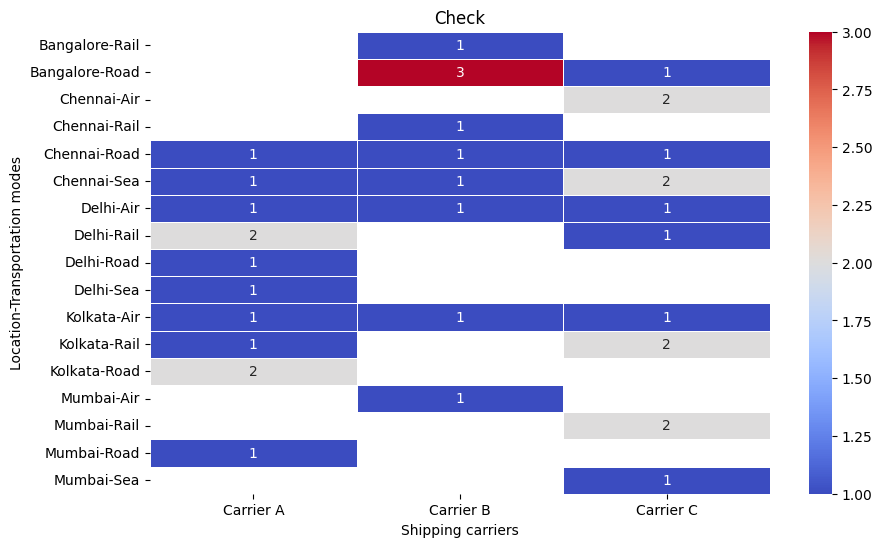

In [148]:
carriers_pivot_locat_transp = fail_df.pivot_table(
    index=['Location', 'Transportation modes'],
    columns='Shipping carriers',
    values='Inspection results',
    aggfunc='count'
) 
plt.figure(figsize=(10, 6))
sns.heatmap(carriers_pivot_locat_transp, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Check')
plt.show()
#The most failure-prone combinations for Carrier A are Delhi + Rail and Kolkata + Road.
#For Carrier B, the highest failure rate is observed on Bangalore + Road.
#For Carrier C, the most problematic pairings are Chennai + Air, Chennai + Sea, Kolkata + Rail, and Mumbai + Rail.

In [149]:
fail_lt = df[df['Inspection results'] == 'Fail']['Lead time'].mean()
fail_lt

16.083333333333332

In [150]:
fail_lt_m = df[df['Inspection results'] == 'Fail']['Manufacturing lead time'].mean()
fail_lt_m #On average, the majority of time (Lead Time) is spent on product production, which is a major concern for Lead Time overall.

12.055555555555555

In [151]:
def Should_to_buy(row):
    total = row['Availability'] + row['Stock levels']
    if total <= 50:
        return 'Should to buy right now'
    elif total <= 100:
        return 'Should to buy soon'
    elif total <= 200:
        return 'Normal Availability'
    else:
        return 'Good Availability'

df['Marker_to_buy'] = df.apply(Should_to_buy, axis=1)
Buy_rightNow = df[df['Marker_to_buy'] == 'Should to buy right now']
Buy_rightNow[['SKU', 'Availability', 'Stock levels']]

,SKU,Availability,Stock levels
2,SKU2,34,1
4,SKU4,26,5
9,SKU9,35,14
18,SKU18,23,10
20,SKU20,22,27
24,SKU24,32,4
29,SKU29,3,45
31,SKU31,28,6
37,SKU37,5,25
43,SKU43,6,36


In [152]:
def Costs_Marker(margin):
    if margin < 10:
        return 'Red flag'
    elif margin < 50:
        return 'Yellow flag'
    else:
        return 'Green flag'

df['Marker_costs'] = df['margin(%)'].apply(Costs_Marker)
Red_flag_orders = df[df['Marker_costs'] == 'Red flag']
Red_flag_orders['Price'].mean()
Red_flag_orders['Manufacturing costs'].mean() #Low price and high production costs = lost profit. The selling price was likely calculated incorrectly.

Red_flag_orders.groupby('Routes')['Routes'].count()
#It has also been verified and confirmed once again that paths A and B incur the greatest costs.

Red_flag_orders[['SKU', 'Price', 'Manufacturing costs']]

,SKU,Price,Manufacturing costs
1,SKU1,14.843523,33.616769
2,SKU2,11.319683,30.688019
4,SKU4,4.805496,92.065161
5,SKU5,1.699976,56.766476
7,SKU7,42.958384,99.466109
10,SKU10,15.707796,96.527353
13,SKU13,16.160393,97.829050
15,SKU15,36.989245,97.121282
16,SKU16,7.547172,77.106342
19,SKU19,51.123870,82.373321


In [153]:
check_margin_on_InspRes = df.groupby('Inspection results')['margin(%)'].mean()
check_margin_on_InspRes #The critical situation of loss of marginality is observed absolutely everywhere.
#The prices for products are set critically incorrectly, which leads to a huge loss of margins.

Inspection results
Fail      -358.151290
Pass      -167.262683
Pending   -145.552406
Name: margin(%), dtype: float64

In [ ]:
import statsmodels.api as sm

X = df[['Price', 'Lead time', 'Defect rates']]
y = df['profit']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
model.summary() #It was found that if the price increases by 1, the profit increases by 573.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     28.89
Date:                Mon, 26 Jan 2026   Prob (F-statistic):           2.13e-13
Time:                        19:42:36   Log-Likelihood:                -1126.8
No. Observations:                 100   AIC:                             2262.
Df Residuals:                      96   BIC:                             2272.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.883e+04   5559.704     -5.186      0.000   -3.99e+04   -1.78e+04
Price          573.4879     64.428      8.901      0.000     445.599     701.377
Lead time       89.0017    235.144      0.378      0.706    -377.756     555.760
Defect rates  -360.0463   1422.350     -0.253      0.801   -3183.389    2463.297
==============================================================================
Omnibus:                        4.599   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                4.015
Skew:                          -0.380   Prob(JB):                        0.134
Kurtosis:                       3.621   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""